# Fitting a linear model with underestimated noise:
# Comparing Metropolis–Hastings and emcee MCMC implementations


In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from scipy.optimize import minimize

# For reproducibility
np.random.seed(42)


## 1. Generate synthetic data

The model is:
$$
y = m x + b + f|mx + b| \epsilon_1 + y_{err} \epsilon_2
$$
where $\epsilon_1, \epsilon_2 \sim \mathcal{N}(0, 1)$.

We'll generate data with known true parameters $m, b, f$ and heteroscedastic errors $y_{err}$.


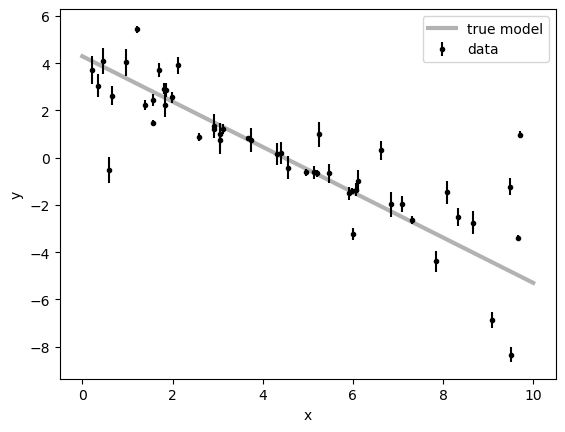

In [2]:
# True parameters
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate data
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)  # heteroscedastic noise
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)  # intrinsic scatter
y += yerr * np.random.randn(N)                # measurement noise

# Plot data with error bars and true line
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0, label="data")
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="true model")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


## 2. Define model, log-likelihood, log-prior, and log-posterior functions

We will define these to use in both Metropolis-Hastings and emcee.


In [3]:
def model(theta, x):
    m, b = theta
    return m * x + b

def log_likelihood(theta, x, y, yerr, f):
    m, b = theta
    model_y = model(theta, x)
    sigma2 = yerr**2 + (f * model_y)**2
    return -0.5 * np.sum((y - model_y)**2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    m, b = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0:
        return 0.0
    return -np.inf

def log_prob(theta, x, y, yerr, f):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr, f)


## 3. Metropolis–Hastings implementation

We will fix $f$ to the true value here for simplicity.


In [4]:
def metropolis_hastings(log_prob_func, initial_theta, args, n_steps=10000, step_sizes=[0.01, 0.1]):
    theta = np.array(initial_theta)
    samples = np.zeros((n_steps, len(initial_theta)))
    samples[0] = theta
    accepts = 0

    current_log_prob = log_prob_func(theta, *args)

    for i in range(1, n_steps):
        proposal = theta + np.random.normal(0, step_sizes, size=theta.shape)
        proposal_log_prob = log_prob_func(proposal, *args)
        log_accept_ratio = proposal_log_prob - current_log_prob

        if np.log(np.random.rand()) < log_accept_ratio:
            theta = proposal
            current_log_prob = proposal_log_prob
            accepts += 1

        samples[i] = theta

    acceptance_rate = accepts / n_steps
    return samples, acceptance_rate


## 4. Run Metropolis–Hastings sampling


In [5]:
initial_theta = [-1.0, 5.0]  # close to true but not exact
n_steps = 10000
step_sizes = [0.01, 0.1]

mh_samples, mh_acceptance = metropolis_hastings(
    log_prob_func=log_prob,
    initial_theta=initial_theta,
    args=(x, y, yerr, f_true),
    n_steps=n_steps,
    step_sizes=step_sizes
)

print(f"MH acceptance rate: {mh_acceptance:.3f}")


MH acceptance rate: 0.643


## 5. Run emcee sampling

We'll initialize walkers near the MH starting point and use the same log-probability function.


In [6]:
ndim = 2
nwalkers = 32

# Initialize walkers in a small Gaussian ball around initial_theta
pos = initial_theta + 1e-4 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(x, y, yerr, f_true))
sampler.run_mcmc(pos, 5000, progress=True);

# Flatten samples, discard burn-in
emcee_samples = sampler.get_chain(discard=1000, flat=True)


100%|██████████| 5000/5000 [00:09<00:00, 527.06it/s]


## 6. Trace plots (MH vs emcee)


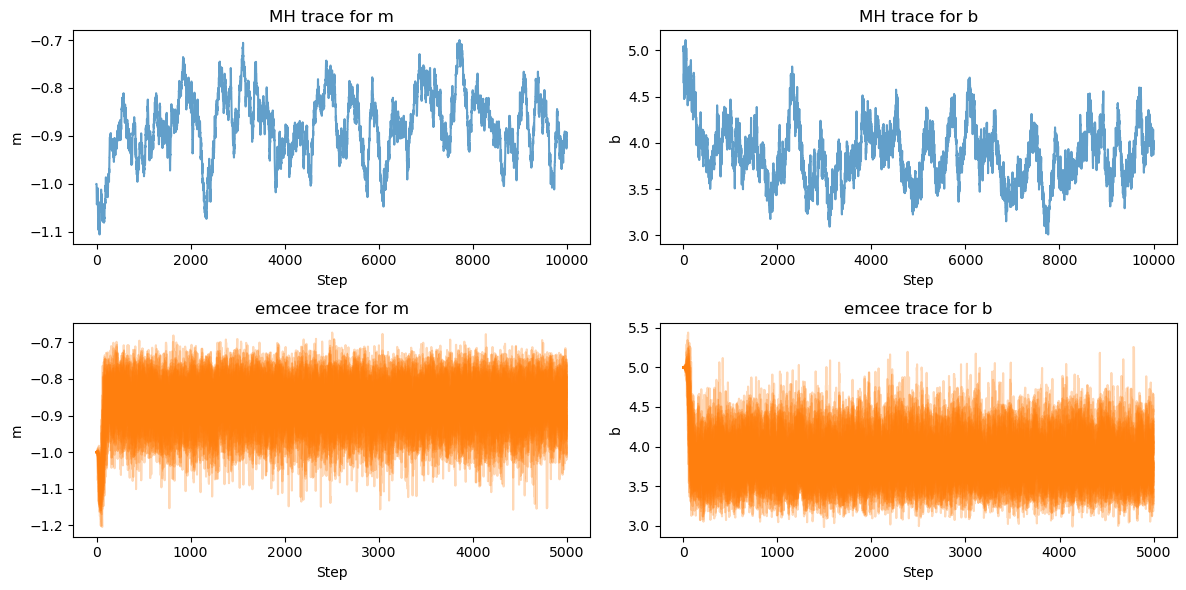

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

labels = ["m", "b"]

# MH trace plots
for i in range(ndim):
    axs[0, i].plot(mh_samples[:, i], color='C0', alpha=0.7)
    axs[0, i].set_title(f"MH trace for {labels[i]}")
    axs[0, i].set_xlabel("Step")
    axs[0, i].set_ylabel(labels[i])

# emcee trace plots (multiple walkers)
for i in range(ndim):
    for walker in range(nwalkers):
        axs[1, i].plot(sampler.get_chain()[:, walker, i], color='C1', alpha=0.3)
    axs[1, i].set_title(f"emcee trace for {labels[i]}")
    axs[1, i].set_xlabel("Step")
    axs[1, i].set_ylabel(labels[i])

plt.tight_layout()
plt.show()


## 7. Histogram comparison of posterior samples


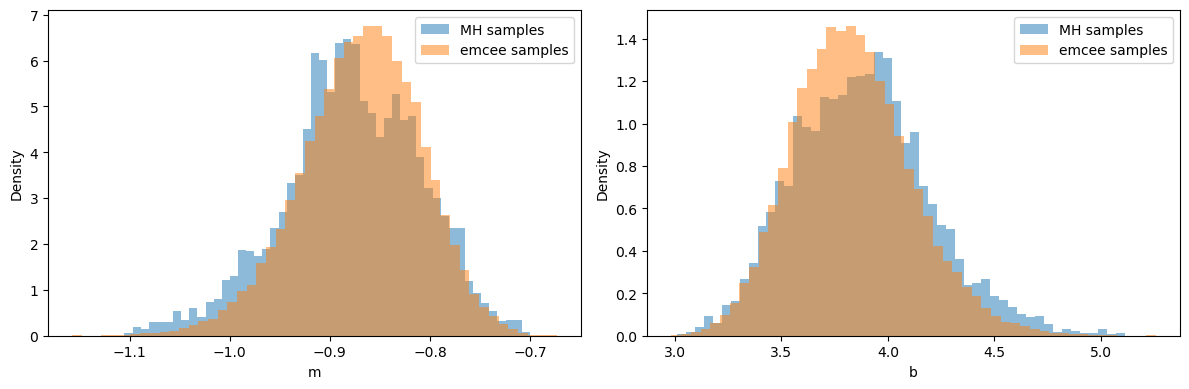

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

for i in range(ndim):
    axs[i].hist(mh_samples[:, i], bins=50, alpha=0.5, label='MH samples', density=True)
    axs[i].hist(emcee_samples[:, i], bins=50, alpha=0.5, label='emcee samples', density=True)
    axs[i].set_xlabel(labels[i])
    axs[i].set_ylabel("Density")
    axs[i].legend()

plt.tight_layout()
plt.show()


## 8. Corner plots comparison


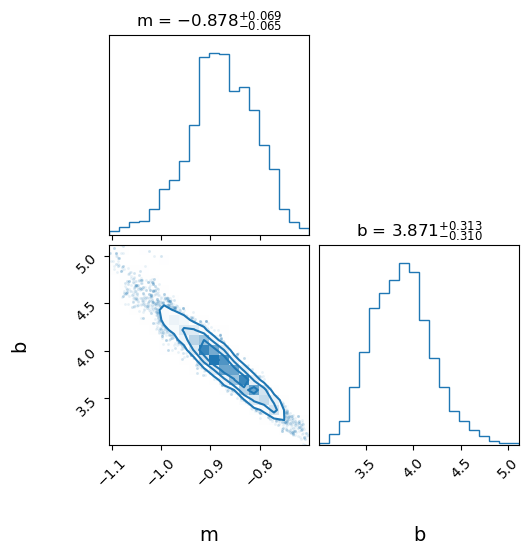

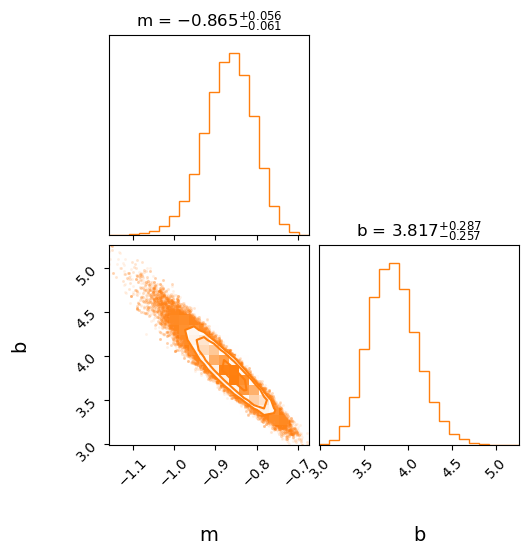

In [10]:
fig = corner.corner(mh_samples, labels=labels, color='C0', show_titles=True, title_fmt=".3f", title_kwargs={"fontsize":12}, label_kwargs={"fontsize":14}, labelpad=0.1)
#plt.suptitle("Metropolis-Hastings posterior", fontsize=16)
plt.show()

fig = corner.corner(emcee_samples, labels=labels, color='C1', show_titles=True, title_fmt=".3f", title_kwargs={"fontsize":12}, label_kwargs={"fontsize":14}, labelpad=0.1)
#plt.suptitle("emcee posterior", fontsize=16)
plt.show()



## 9. Parameter estimates

We report median and 16th/84th percentiles for MH and emcee samples.


In [11]:
def print_mcmc_results(samples, labels):
    for i, label in enumerate(labels):
        mcmc = np.percentile(samples[:, i], [16, 50, 84])
        low_err = mcmc[1] - mcmc[0]
        high_err = mcmc[2] - mcmc[1]
        print(f"{label} = {mcmc[1]:.3f} +{high_err:.3f} -{low_err:.3f}")

print("MH results:")
print_mcmc_results(mh_samples, labels)

print("\nemcee results:")
print_mcmc_results(emcee_samples, labels)


MH results:
m = -0.878 +0.069 -0.065
b = 3.871 +0.313 -0.310

emcee results:
m = -0.865 +0.056 -0.061
b = 3.817 +0.287 -0.257
